In [0]:
# !pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # (1461, 1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))  # (m, window_size, 1)
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200) 
  ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 398ms/step - loss: 93.0267 - mae: 93.3767
Epoch 2/100
8/8 [==============================] - 1s 66ms/step - loss: 92.5332 - mae: 93.1235
Epoch 3/100
8/8 [==============================] - 1s 64ms/step - loss: 92.0309 - mae: 92.7157
Epoch 4/100
8/8 [==============================] - 1s 65ms/step - loss: 91.6662 - mae: 92.2044
Epoch 5/100
8/8 [==============================] - 1s 65ms/step - loss: 91.0046 - mae: 91.6040
Epoch 6/100
8/8 [==============================] - 1s 63ms/step - loss: 90.4007 - mae: 90.9168
Epoch 7/100
8/8 [==============================] - 0s 62ms/step - loss: 89.7102 - mae: 90.1297
Epoch 8/100
8/8 [==============================] - 0s 60ms/step - loss: 88.5958 - mae: 89.2418
Epoch 9/100
8/8 [==============================] - 1s 64ms/step - loss: 87.6654 - mae: 88.2330
Epoch 10/100
8/8 [==============================] - 1s 63ms/step - loss: 86.4128 - mae: 87.0912
Epoch 11/100
8/8 [==============================

[1e-08, 0.0001, 0, 30]

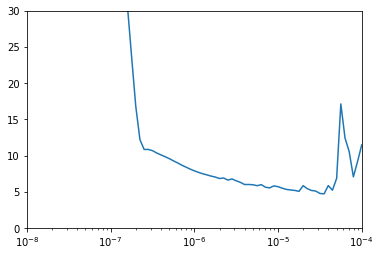

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
batch_size = 32
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
16/16 [==============================] - 3s 201ms/step - loss: 28.4905 - mae: 29.7330
Epoch 2/500
16/16 [==============================] - 1s 41ms/step - loss: 10.8284 - mae: 11.1921
Epoch 3/500
16/16 [==============================] - 1s 43ms/step - loss: 7.5718 - mae: 8.2354
Epoch 4/500
16/16 [==============================] - 1s 42ms/step - loss: 6.5818 - mae: 7.1609
Epoch 5/500
16/16 [==============================] - 1s 42ms/step - loss: 5.8520 - mae: 6.3939
Epoch 6/500
16/16 [==============================] - 1s 41ms/step - loss: 5.5756 - mae: 6.0058
Epoch 7/500
16/16 [==============================] - 1s 43ms/step - loss: 5.4169 - mae: 5.7705
Epoch 8/500
16/16 [==============================] - 1s 43ms/step - loss: 5.6606 - mae: 6.2574
Epoch 9/500
16/16 [==============================] - 1s 42ms/step - loss: 5.0578 - mae: 5.5274
Epoch 10/500
16/16 [==============================] - 1s 43ms/step - loss: 5.9061 - mae: 6.0404
Epoch 11/500
16/16 [========================

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]

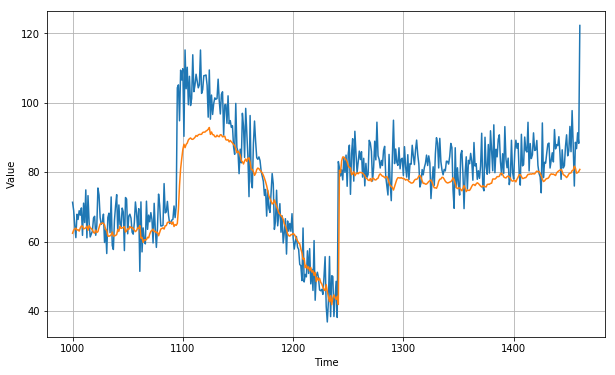

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.4937673

<Figure size 432x288 with 0 Axes>

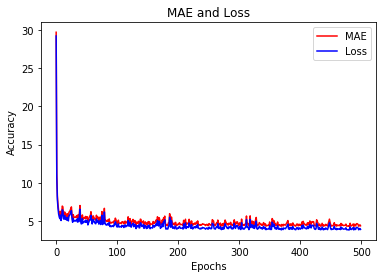

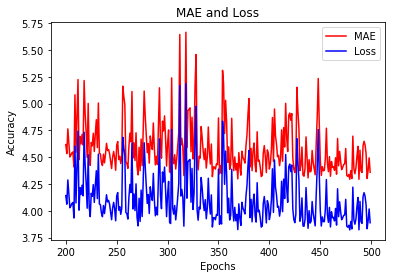

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()